In [88]:
import pandas as pd
import geopandas as gpd

df = pd.read_csv("/Users/lingyunhuang/Desktop/BENV0093 spatial/2nd_Assignment-20251126/datasets/REPD_Publication_Q3_2025.csv",encoding='latin1')

df.columns

Index(['Old Ref ID', 'Ref ID', 'Record Last Updated (dd/mm/yyyy)',
       'Operator (or Applicant)', 'Site Name', 'Technology Type',
       'Storage Type', 'Storage Co-location REPD Ref ID',
       'Installed Capacity (MWelec)', 'Share Community Scheme', 'CHP Enabled',
       'CfD Allocation Round', 'RO Banding (ROC/MWh)', 'FiT Tariff (p/kWh)',
       'CfD Capacity (MW)', 'Turbine Capacity', 'No. of Turbines',
       'Height of Turbines (m)', 'Mounting Type for Solar',
       'Development Status', 'Development Status (short)',
       'Are they re-applying (New REPD Ref)',
       'Are they re-applying (Old REPD Ref) ', 'Address', 'County', 'Region',
       'Country', 'Post Code', 'X-coordinate', 'Y-coordinate',
       'Planning Authority', 'Planning Application Reference',
       'Appeal Reference', 'Secretary of State Reference',
       'Type of Secretary of State Intervention', 'Judicial Review',
       'Offshore Wind Round', 'Planning Application Submitted',
       'Planning Applicat

In [89]:
df['Technology Type'].unique()

array(['Biomass (co-firing)', 'EfW Incineration', 'Biomass (dedicated)',
       'Advanced Conversion Technologies', 'Anaerobic Digestion',
       'Large Hydro', 'Small Hydro', 'Battery', 'Landfill Gas',
       'Solar Photovoltaics', 'Sewage Sludge Digestion', 'Tidal Stream',
       'Tidal Lagoon', 'Shoreline Wave', 'Wind Offshore', 'Wind Onshore',
       'Hot Dry Rocks (HDR)', 'Pumped Storage Hydroelectricity',
       'Liquid Air Energy Storage', 'Flywheels', 'Fuel Cell (Hydrogen)',
       'Hydrogen', 'Compressed Air Energy Storage', 'Geothermal',
       'Unknown', 'Air Source Heat Pumps'], dtype=object)

In [90]:
onshore = "Wind Onshore"
df_wind = df[df['Technology Type'] == onshore].copy()
df_wind['Development Status (short)'].unique()

array(['Application Refused', 'Abandoned', 'Operational',
       'Application Withdrawn', 'Appeal Refused', 'Revised',
       'Awaiting Construction', 'Planning Permission Expired',
       'Under Construction', 'Application Submitted', 'Decommissioned',
       'Appeal Withdrawn', 'Appeal Lodged', 'No Application Required'],
      dtype=object)

In [91]:
valid_statuses = [
    'Operational', 
    'Under Construction', 
    'Awaiting Construction', 
    'Application Submitted', 
    'Appeal Lodged',
    'Revised'
]
df_wind = df_wind[df_wind['Development Status (short)'].isin(valid_statuses)]

check the null value and do data cleaning

In [92]:
print(
df_wind['X-coordinate'].isnull().sum(),
df_wind['Y-coordinate'].isnull().sum()
)

4 4


In [93]:
df_wind = df_wind.dropna(subset=['X-coordinate', 'Y-coordinate'])

In [94]:
gdf_wind = gpd.GeoDataFrame(
    df_wind, 
    geometry=gpd.points_from_xy(df_wind['X-coordinate'], df_wind['Y-coordinate']),
    crs="EPSG:27700"
)

print(len(gdf_wind))


1648


In [95]:
df_wind['Installed Capacity (MWelec)']

2071      1.50
2072      1.50
2073     10.20
2076     58.50
2077     16.80
         ...  
13468    64.80
13482     4.26
13484      NaN
13491    34.00
13521    72.00
Name: Installed Capacity (MWelec), Length: 1648, dtype: object

do data cleaning for `Installed capacity (MW)`

In [96]:
df_wind['Installed Capacity (MWelec)'].isnull().sum()

80

In [97]:
df_wind['Installed Capacity (MWelec)'].dropna(inplace=True)

we only need Installed Capacity (MWe) > 20

In [98]:
threshold = 20
df_wind['Installed Capacity (MWelec)'] = pd.to_numeric(df_wind['Installed Capacity (MWelec)'])
df_wind_large = df_wind[df_wind['Installed Capacity (MWelec)'] >= threshold]

gdf_wind = gpd.GeoDataFrame(
    df_wind_large, 
    geometry=gpd.points_from_xy(df_wind_large['X-coordinate'], df_wind_large['Y-coordinate']),
    crs="EPSG:27700"
)

len(gdf_wind)


564

In [99]:
gdf_lines = gpd.read_file("/Users/lingyunhuang/Desktop/BENV0093 spatial/2nd_Assignment-20251126/datasets/uk_transmission_lines.geojson")

gdf_lines = gdf_lines.to_crs("EPSG:27700")


In [100]:
operational = gdf_wind[gdf_wind['Development Status (short)'] == 'Operational']

construction = gdf_wind[gdf_wind['Development Status (short)'] == 'Under Construction']

planned_status_list = [
    'Awaiting Construction', 
    'Application Submitted', 
    'Appeal Lodged',
    'Revised'
]

planned = gdf_wind[gdf_wind['Development Status (short)'].isin(planned_status_list)]


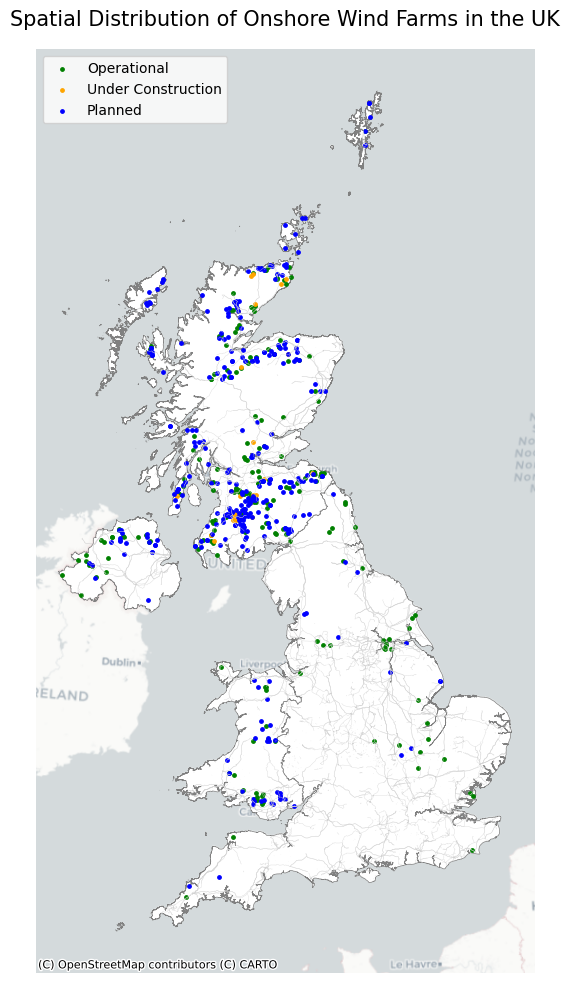

In [171]:
import matplotlib.pyplot as plt

uk_boundary_path = "/Users/lingyunhuang/Desktop/BENV0093 spatial/2nd_Assignment-20251126/datasets/CTRY_DEC_2024_UK_BGC.shp" 
uk_boundary = gpd.read_file(uk_boundary_path)

uk_boundary = uk_boundary.to_crs("EPSG:27700")

fig, ax = plt.subplots(figsize=(10, 12))

uk_boundary.plot(ax=ax, facecolor="#ffffff", edgecolor='grey', linewidth=0.5)

gdf_lines.plot(ax=ax, color='lightgrey', linewidth=0.3, alpha=0.8)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs="EPSG:27700", zoom=6)

operational.plot(ax=ax, color='green', markersize=6, label='Operational')
construction.plot(ax=ax, color='orange', markersize=6, label='Under Construction')
planned.plot(ax=ax, color='blue', markersize=6, label='Planned')

ax.set_title("Spatial Distribution of Onshore Wind Farms in the UK", fontsize=15)
ax.legend(loc='upper left')
ax.set_axis_off()

plt.show()

## onshore and offshore comparasion

In [102]:
df_onshore = df[
    (df['Technology Type'] == 'Wind Onshore') & 
    (df['Development Status (short)'].isin(valid_statuses))
].copy()

df_offshore = df[
    (df['Technology Type'] == 'Wind Offshore') & 
    (df['Development Status (short)'].isin(valid_statuses))
].copy()

In [103]:
print(
df_onshore['X-coordinate'].isnull().sum(),
df_offshore['X-coordinate'].isnull().sum()
)

4 7


In [104]:
df_onshore = df_onshore.dropna(subset=['X-coordinate', 'Y-coordinate'])
df_offshore = df_offshore.dropna(subset=['X-coordinate', 'Y-coordinate'])

## Kernel Density Map

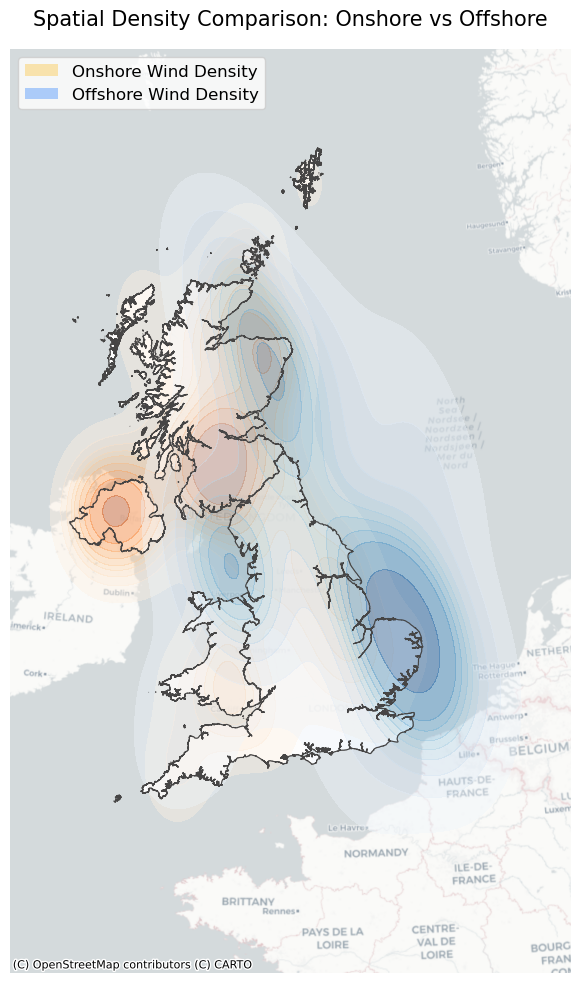

In [105]:
import seaborn as sns
from matplotlib.patches import Patch
import contextily as cx

df_onshore['X-coordinate'] = pd.to_numeric(df_onshore['X-coordinate'])
df_onshore['Y-coordinate'] = pd.to_numeric(df_onshore['Y-coordinate'])
df_offshore['X-coordinate'] = pd.to_numeric(df_offshore['X-coordinate'])
df_offshore['Y-coordinate'] = pd.to_numeric(df_offshore['Y-coordinate'])

fig, ax = plt.subplots(figsize=(8, 12))
uk_boundary.plot(ax=ax, facecolor="#ffffff", edgecolor='grey', linewidth=0.8, alpha=0.8, zorder=1)

sns.kdeplot(
    x=df_onshore['X-coordinate'], 
    y=df_onshore['Y-coordinate'],
    cmap="Oranges", 
    fill=True, 
    thresh=0.05, 
    alpha=0.4, 
    ax=ax,
    label='Onshore Density',
    zorder=2
)

sns.kdeplot(
    x=df_offshore['X-coordinate'], 
    y=df_offshore['Y-coordinate'],
    cmap="Blues", 
    fill=True, 
    thresh=0.05, 
    alpha=0.4, 
    ax=ax,
    label='Offshore Density',
    zorder=3
)

uk_boundary.plot(ax=ax, facecolor='none', edgecolor="#464545", linewidth=0.8, zorder=4)

legend_elements = [
    Patch(facecolor="#ffb300", edgecolor='none', alpha=0.3, label='Onshore Wind Density'),
    Patch(facecolor="#0066ff", edgecolor='none', alpha=0.3, label='Offshore Wind Density')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=12, frameon=True, fancybox=True)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs="EPSG:27700", zoom=6)

ax.set_title("Spatial Density Comparison: Onshore vs Offshore", fontsize=15)
ax.set_axis_off()

plt.show()


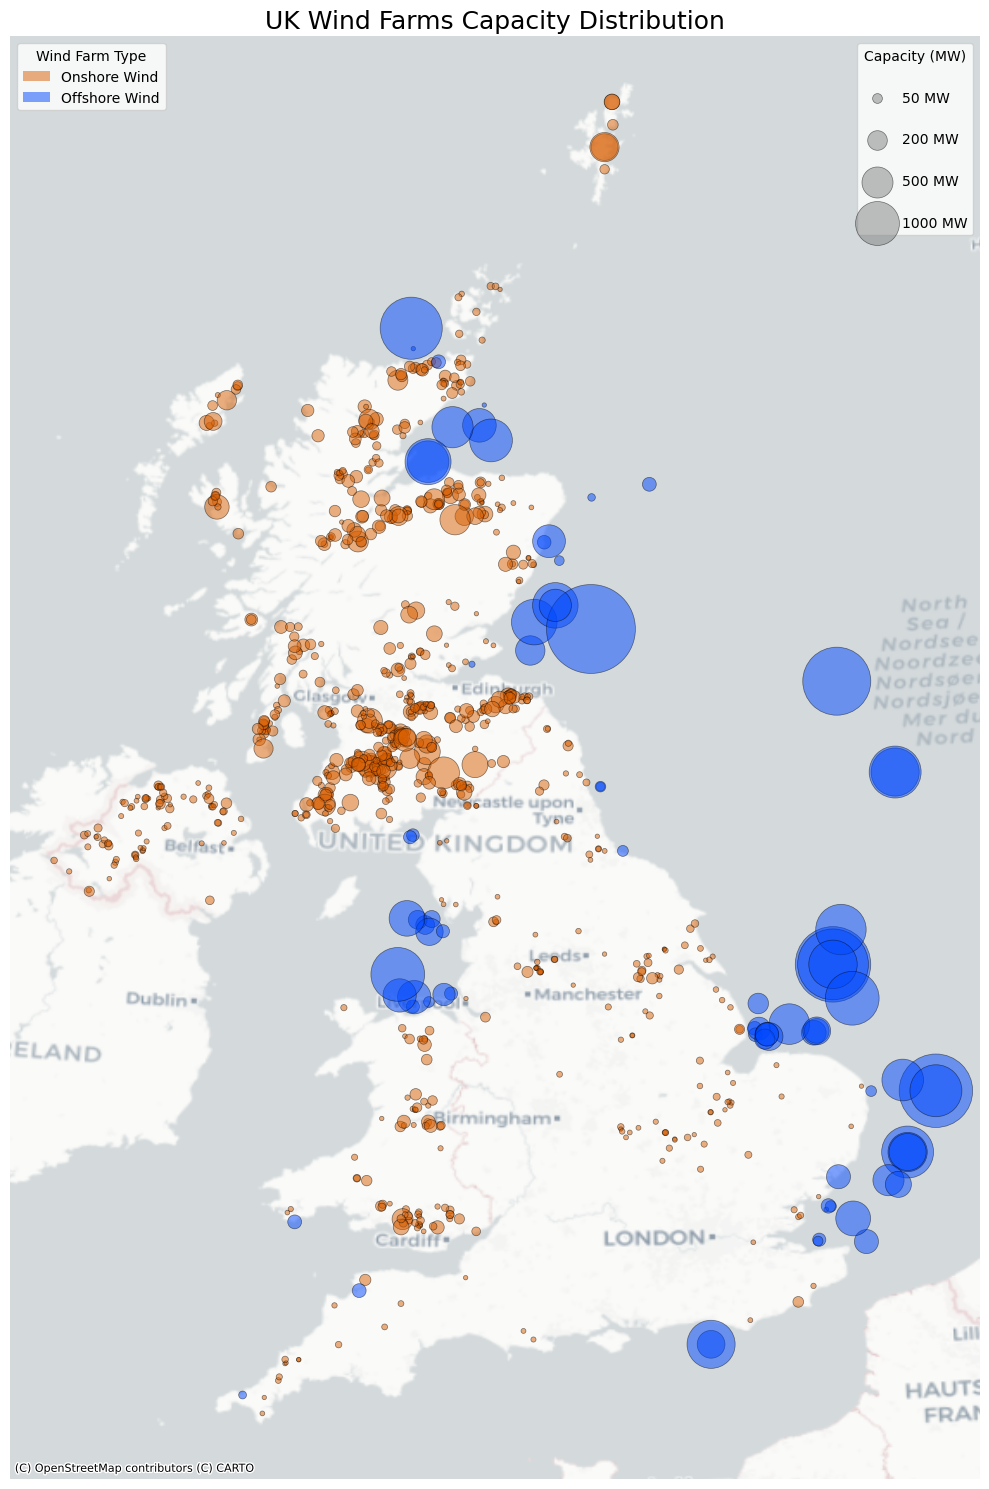

In [106]:
fig, ax = plt.subplots(figsize=(10, 15))

scale_factor = 1 

threshold = 10

df_onshore['Installed Capacity (MWelec)'] = pd.to_numeric(df_onshore['Installed Capacity (MWelec)'], errors='coerce')
df_onshore = df_onshore[df_onshore['Installed Capacity (MWelec)'] >= threshold]

df_offshore['Installed Capacity (MWelec)'] = pd.to_numeric(df_offshore['Installed Capacity (MWelec)'], errors='coerce')
df_offshore = df_offshore[df_offshore['Installed Capacity (MWelec)'] >= threshold]

min = 0
on_sizes = df_onshore['Installed Capacity (MWelec)'].fillna(min) * scale_factor
off_sizes = df_offshore['Installed Capacity (MWelec)'].fillna(min) * scale_factor

on_x = pd.to_numeric(df_onshore['X-coordinate'], errors='coerce')
on_y = pd.to_numeric(df_onshore['Y-coordinate'], errors='coerce')

off_x = pd.to_numeric(df_offshore['X-coordinate'], errors='coerce')
off_y = pd.to_numeric(df_offshore['Y-coordinate'], errors='coerce')

ax.scatter(
    on_x,
    on_y,
    s=on_sizes,
    c='#d95f02',
    edgecolor='black',
    linewidth=0.5,
    alpha=0.5,
    label='Onshore Wind'
)

ax.scatter(
    off_x,
    off_y,
    s=off_sizes,
    c="#0048ff",
    edgecolor='black',
    linewidth=0.5,
    alpha=0.5,
    label='Offshore Wind'
)



legend_elements_color = [
    Patch(facecolor="#d95f02", edgecolor='none', alpha=0.5, label='Onshore Wind'),
    Patch(facecolor="#0048ff", edgecolor='none', alpha=0.5, label='Offshore Wind')
]

#1
first_legend = ax.legend(
    handles=legend_elements_color, 
    loc='upper left', 
    title="Wind Farm Type", 
    fontsize=10
)

ax.add_artist(first_legend)

#2
legend_sizes_mw = [50, 200, 500, 1000] 
legend_elements_size = []

for mw in legend_sizes_mw:
    area_size = mw * scale_factor 
    handle = ax.scatter(
        [], [],
        s=area_size, 
        c='gray', 
        edgecolor='black', 
        linewidth=0.5, 
        alpha=0.5,
        label=f'{mw} MW'
    )
    legend_elements_size.append(handle)

ax.legend(
    handles=legend_elements_size, 
    loc='upper right', 
    title="Capacity (MW)", 
    fontsize=10, 
    labelspacing=2
)


cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs="EPSG:27700", zoom=6)

ax.set_title("UK Wind Farms Capacity Distribution", fontsize=18)
ax.set_axis_off()
plt.tight_layout()
plt.show()


## AHP

In [107]:
import numpy as np

# wind speed > grid proximity > slope
matrix = np.array([
    [1,   3,   7],
    [1/3, 1,   3],
    [1/7, 1/3, 1]
])


In [108]:
eig_val, eig_vec = np.linalg.eig(matrix)
max_eig_val = np.max(eig_val).real
eig_vec_max = eig_vec[:, np.argmax(eig_val)].real
weights = eig_vec_max / np.sum(eig_vec_max)

In [109]:
n = 3
RI = 0.58
CI = (max_eig_val - n) / (n - 1)
CR = CI / RI

In [110]:
factors = ['Wind Speed', 'Distance to Grid', 'Slope']
print("Final Weights")
for f, w in zip(factors, weights):
    print(f"{f}: {w:.3f} ({w*100:.1f}%)")

print(f"\nLambda Max: {max_eig_val:.3f}")
print(f"CR: {CR:.3f} (< 0.1)")

Final Weights
Wind Speed: 0.669 (66.9%)
Distance to Grid: 0.243 (24.3%)
Slope: 0.088 (8.8%)

Lambda Max: 3.007
CR: 0.006 (< 0.1)


# 4. Results

## 4.1 Spatial Analysis

In [111]:
import xarray as xr
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box

wind speed data

In [112]:
wind_nc = xr.open_dataset("/Users/lingyunhuang/Desktop/BENV0093 spatial/2nd_Assignment-20251126/datasets/wind_speed.nc")

In [113]:
wind_nc.info

<bound method Dataset.info of <xarray.Dataset> Size: 987kB
Dimensions:      (y: 235, x: 131, season: 4)
Coordinates:
  * y            (y) int32 940B 12500 17500 22500 ... 1172500 1177500 1182500
  * x            (x) int32 524B 2500 7500 12500 17500 ... 642500 647500 652500
  * season       (season) object 32B 'spring' 'summer' 'autumn' 'winter'
Data variables:
    wind_speed   (season, y, x) float64 985kB ...
    spatial_ref  int32 4B ...>

In [114]:
wind_data = wind_nc['wind_speed']
wind_data.rio.write_crs("EPSG:27700", inplace=True)

<xarray.DataArray 'wind_speed' (season: 4, y: 235, x: 131)> Size: 985kB
[123140 values with dtype=float64]
Coordinates:
  * y            (y) int32 940B 12500 17500 22500 ... 1172500 1177500 1182500
  * x            (x) int32 524B 2500 7500 12500 17500 ... 642500 647500 652500
  * season       (season) object 32B 'spring' 'summer' 'autumn' 'winter'
    spatial_ref  int64 8B 0
Attributes:
    units:        m s⁻¹
    description:  Seasonal baseline median wind speed (5 km grid, masked outs...

annual average wind speed

In [115]:
wind_annual = wind_data.mean(dim='season') 
wind_annual

<xarray.DataArray 'wind_speed' (y: 235, x: 131)> Size: 246kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y            (y) int32 940B 12500 17500 22500 ... 1172500 1177500 1182500
  * x            (x) int32 524B 2500 7500 12500 17500 ... 642500 647500 652500
    spatial_ref  int64 8B 0

terriain data

In [116]:
terrain = rioxarray.open_rasterio("/Users/lingyunhuang/Desktop/BENV0093 spatial/2nd_Assignment-20251126/datasets/terrain.tif")
terrain = terrain.rio.reproject_match(wind_annual).squeeze()
terrain

<xarray.DataArray (y: 235, x: 131)> Size: 123kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0
  * x            (x) int32 524B 2500 7500 12500 17500 ... 642500 647500 652500
  * y            (y) int32 940B 12500 17500 22500 ... 1172500 1177500 1182500
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  1347
    STATISTICS_MEAN:     350
    STATISTICS_MINIMUM:  -20
    STATISTICS_STDDEV:   300
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           band_data
    _FillValue:          nan

slope calculation

In [117]:
px, py = np.gradient(terrain.values, 5000, 5000)
slope_rad = np.arctan(np.sqrt(px**2 + py**2))
slope_deg = np.degrees(slope_rad)
slope_xr = xr.DataArray(slope_deg, coords=wind_annual.coords, dims=wind_annual.dims)

In [118]:
slope_xr

<xarray.DataArray (y: 235, x: 131)> Size: 123kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * y            (y) int32 940B 12500 17500 22500 ... 1172500 1177500 1182500
  * x            (x) int32 524B 2500 7500 12500 17500 ... 642500 647500 652500
    spatial_ref  int64 8B 0

transmission line data

In [119]:
transmission_lines = gpd.read_file("/Users/lingyunhuang/Desktop/BENV0093 spatial/2nd_Assignment-20251126/datasets/uk_transmission_lines.geojson")
transmission_lines = transmission_lines.to_crs("EPSG:27700")


In [120]:
transmission_lines.head(3)

,element,id,power,source,frequency,location,operator,operator:wikidata,phases,start_date,...,lines,barrier,waterway,width,steps,FIXME,communication,seamark:cable_overhead:clearance_height,tunnel,geometry
0,way,2800252,line,None,50,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (505764.554 162573.082, 505624.085 ..."
1,way,2837943,line,None,None,None,UK Power Networks,Q7864927,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (504041.86 161100.535, 504030.57 16..."
2,way,3184517,line,None,None,None,UK Power Networks,Q7864927,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (505627.823 161565.093, 505629.812 ..."


In [121]:
X, Y = np.meshgrid(wind_annual.x, wind_annual.y)
raster_points = gpd.GeoSeries(gpd.points_from_xy(X.flatten(), Y.flatten()), crs="EPSG:27700")

In [122]:
transmisison_union = transmission_lines.unary_union
distance_values = raster_points.distance(transmisison_union)

dist_grid_xr = xr.DataArray(
    distance_values.values.reshape(wind_annual.shape),
    coords=wind_annual.coords,
    dims=wind_annual.dims
)


/var/folders/jj/k27ndf3n34z0bf8kx6q4_fqc0000gn/T/ipykernel_8599/3704551365.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  transmisison_union = transmission_lines.unary_union


## scaling

In [123]:
def normalize(x, reverse=False):
    min_val = x.min()
    max_val = x.max()
    if reverse:
        return (max_val - x) / (max_val - min_val)
    else:
        return (x - min_val) / (max_val - min_val)


In [124]:
score_wind = normalize(wind_annual, reverse=False)
score_distance = normalize(dist_grid_xr, reverse=True) # not good since did not limit the max distance
score_slope = normalize(slope_xr, reverse=True)

In [125]:
# From other studys, distance to grid's limit is around 50km
threshold_dist = 50000
dist_clipped = dist_grid_xr.clip(max=threshold_dist)
score_distance_optimized = 1 - (dist_clipped / threshold_dist)

plot

## wind speed plot

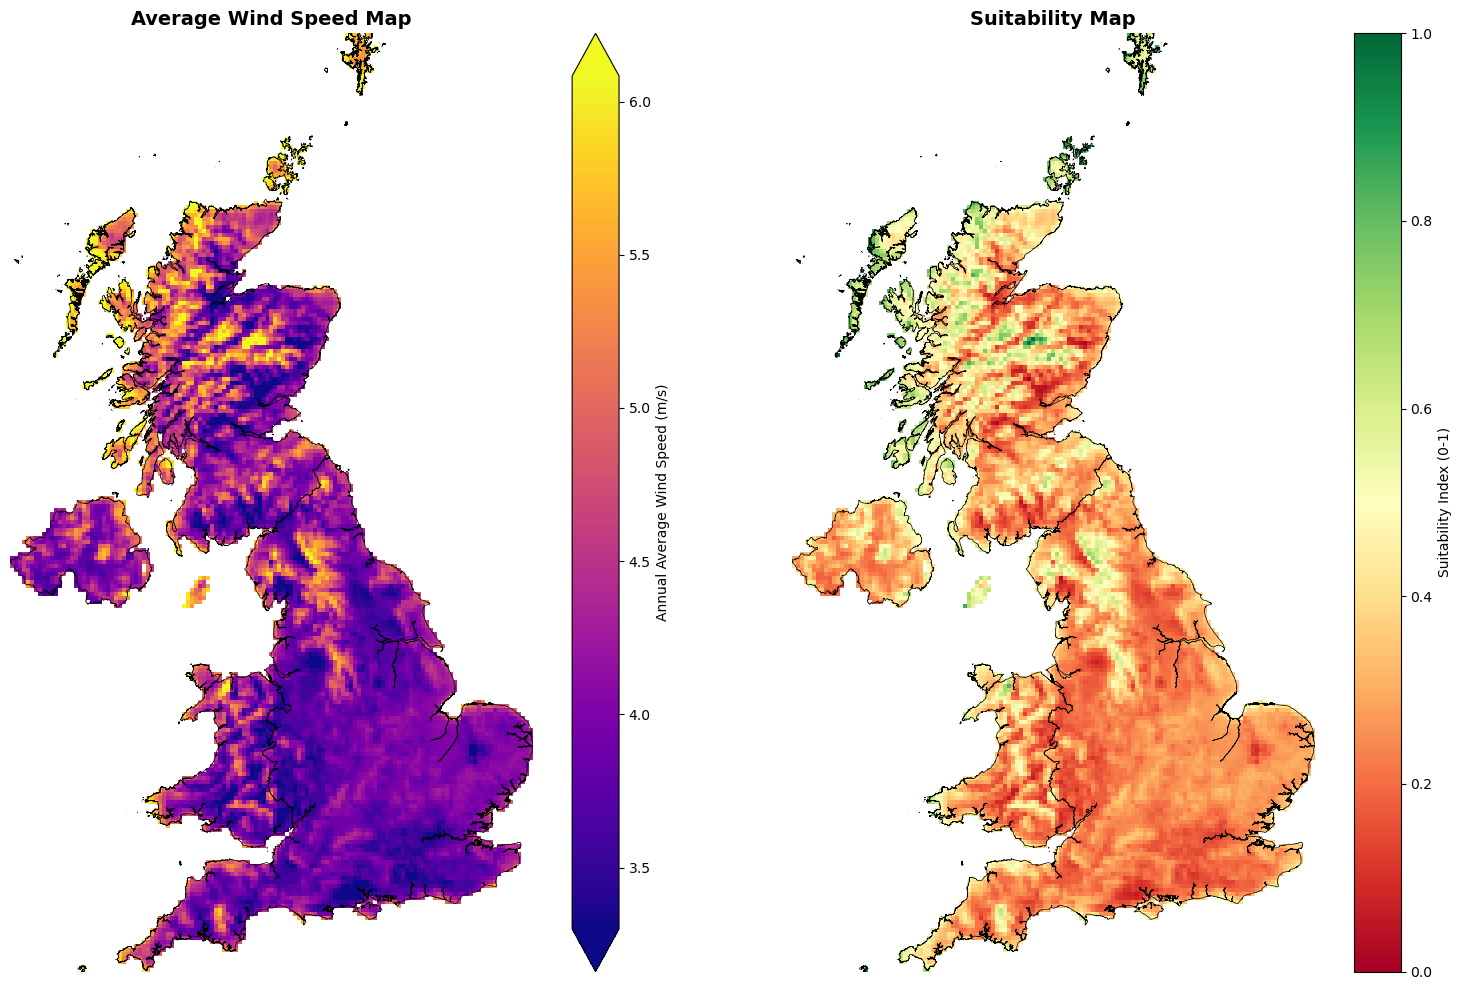

In [126]:
fig, axes = plt.subplots(1, 2, figsize=(16, 10))
gdf_uk = gpd.read_file("/Users/lingyunhuang/Desktop/BENV0093 spatial/2nd_Assignment-20251126/datasets/CTRY_DEC_2024_UK_BGC.shp")
gdf_uk = gdf_uk.to_crs("EPSG:27700")
gdf_uk.plot(ax=axes[0], facecolor='none', edgecolor='black', linewidth=0.5, zorder=2)


wind_annual.plot(ax=axes[0], cmap='plasma', cbar_kwargs={'label': 'Annual Average Wind Speed (m/s)'}, zorder=1, robust=True)

axes[0].set_title("Average Wind Speed Map", fontsize=14, fontweight='bold')
axes[0].set_axis_off()

###

gdf_uk.plot(ax=axes[1], facecolor='none', edgecolor='black', linewidth=0.5, zorder=2)

score_wind.plot(ax=axes[1], cmap='RdYlGn', vmin=0, vmax=1, cbar_kwargs={'label': 'Suitability Index (0-1)'}, zorder=1)

axes[1].set_title("Suitability Map", fontsize=14, fontweight='bold')
axes[1].set_axis_off()

plt.tight_layout()
plt.show()


## splope map

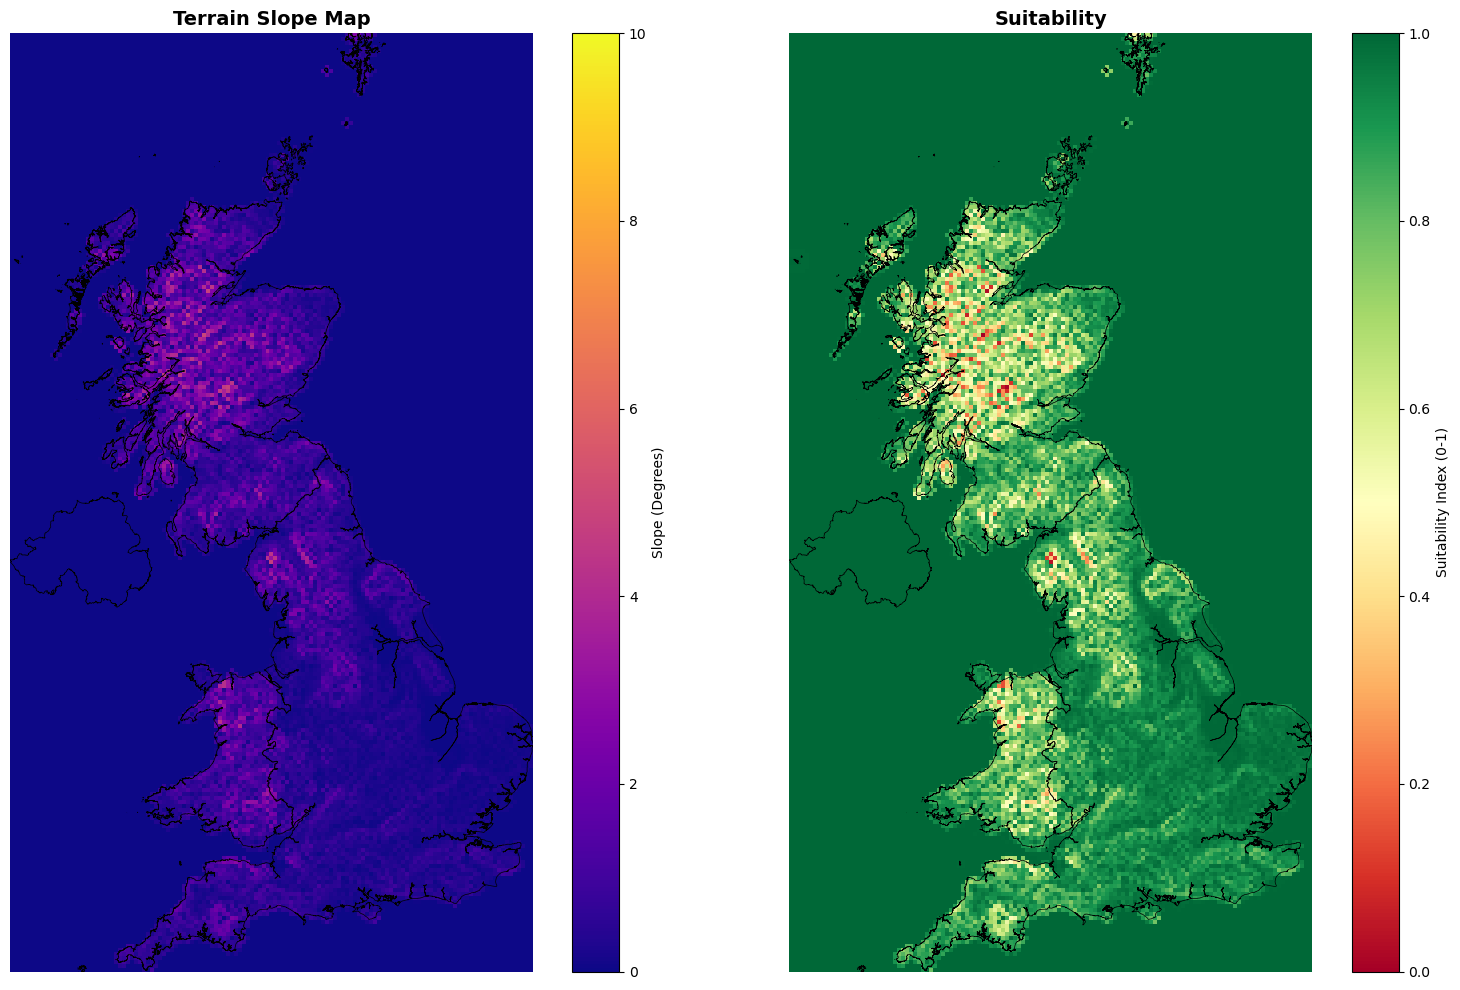

In [127]:
fig, axes = plt.subplots(1, 2, figsize=(16, 10))


gdf_uk.plot(ax=axes[0], facecolor='none', edgecolor='black', linewidth=0.5, zorder=2)

slope_xr.plot(ax=axes[0], cmap='plasma', vmin=0, vmax=10, cbar_kwargs={'label': 'Slope (Degrees)'}, zorder=1)

axes[0].set_title("Terrain Slope Map", fontsize=14, fontweight='bold')
axes[0].set_axis_off()

###

gdf_uk.plot(ax=axes[1], facecolor='none', edgecolor='black', linewidth=0.5, zorder=2)


score_slope.plot(ax=axes[1], cmap='RdYlGn', vmin=0, vmax=1, cbar_kwargs={'label': 'Suitability Index (0-1)'}, zorder=1)

axes[1].set_title("Suitability", fontsize=14, fontweight='bold')
axes[1].set_axis_off()

plt.tight_layout()
plt.show()

## transmission line map

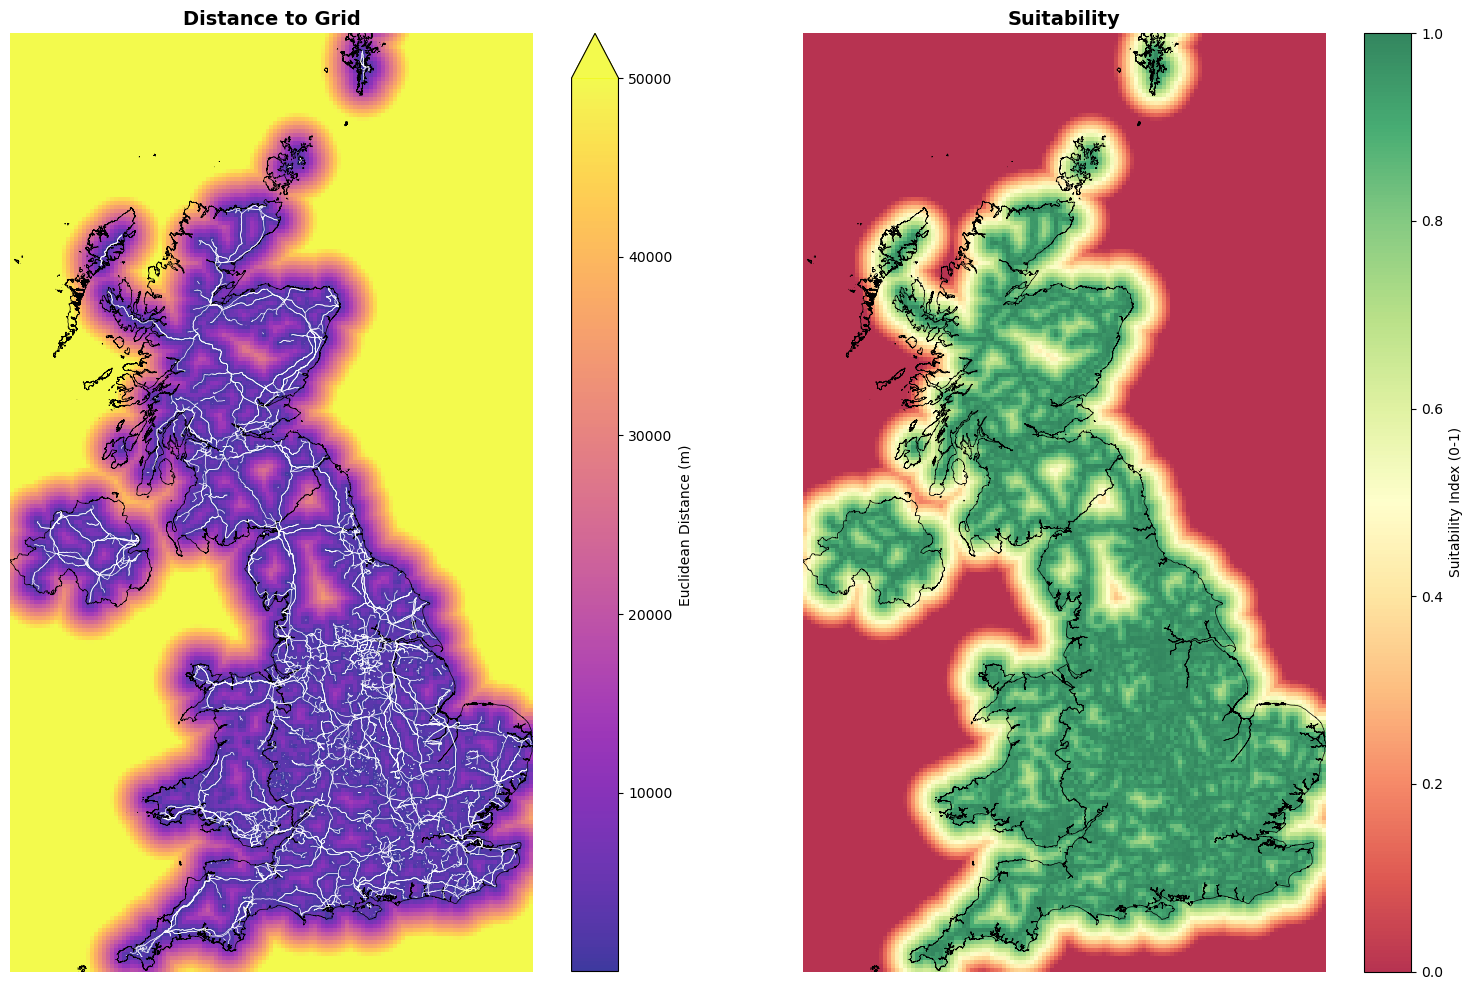

In [128]:
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

transmission_lines.plot(ax=axes[0], color='white', linewidth=0.5, zorder=3)


gdf_uk.plot(ax=axes[0], facecolor='none', edgecolor='black', linewidth=0.5, zorder=2)

dist_grid_xr.plot(ax=axes[0], cmap='plasma', vmax=threshold_dist, alpha=0.8, cbar_kwargs={'label': 'Euclidean Distance (m)'}, zorder=1)

axes[0].set_title("Distance to Grid", fontsize=14, fontweight='bold')
axes[0].set_axis_off()

###

gdf_uk.plot(ax=axes[1], facecolor='none', edgecolor='black', linewidth=0.5, zorder=2)

score_distance_optimized.plot(ax=axes[1], cmap='RdYlGn', vmin=0, vmax=1, alpha=0.8, cbar_kwargs={'label': 'Suitability Index (0-1)'}, zorder=1)

axes[1].set_title("Suitability", fontsize=14, fontweight='bold')
axes[1].set_axis_off()

plt.tight_layout()
plt.show()

## Constraints

### slope constraint

slope > 15 degreee is not suitable

In [129]:
constraint_slope = xr.where(slope_xr > 15, 0, 1)

In [130]:
slope_xr.rio.write_crs("EPSG:27700", inplace=True)
slope_land = slope_xr.rio.clip(gdf_uk.geometry, gdf_uk.crs, drop=True, all_touched=True)
plot_data = xr.where(constraint_slope == 0, 1, np.nan)


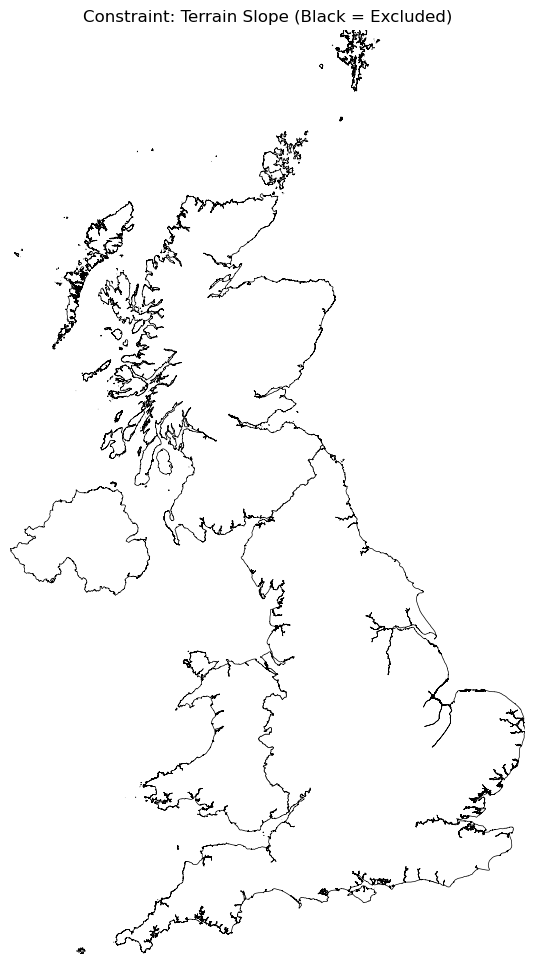

In [131]:
fig, ax = plt.subplots(figsize=(10, 12))

gdf_uk.plot(
    ax=ax, 
    facecolor='White', 
    edgecolor='Black', 
    linewidth=0.5, 
    zorder=1
)

plot_data.plot(ax=ax, cmap='gray', add_colorbar=False)
ax.set_title("Constraint: Terrain Slope (Black = Excluded)")
ax.set_axis_off()
plt.show()

### protected area constraint

In [132]:
gdf_0 = gpd.read_file("/Users/lingyunhuang/Desktop/BENV0093 spatial/2nd_Assignment-20251126/datasets/WDPA_WDOECM_Jan2026_Public_GBR_shp/WDPA_WDOECM_Jan2026_Public_GBR_shp_0/WDPA_WDOECM_Jan2026_Public_GBR_shp-polygons.shp")
gdf_1 = gpd.read_file("/Users/lingyunhuang/Desktop/BENV0093 spatial/2nd_Assignment-20251126/datasets/WDPA_WDOECM_Jan2026_Public_GBR_shp/WDPA_WDOECM_Jan2026_Public_GBR_shp_1/WDPA_WDOECM_Jan2026_Public_GBR_shp-polygons.shp")
gdf_2 = gpd.read_file("/Users/lingyunhuang/Desktop/BENV0093 spatial/2nd_Assignment-20251126/datasets/WDPA_WDOECM_Jan2026_Public_GBR_shp/WDPA_WDOECM_Jan2026_Public_GBR_shp_2/WDPA_WDOECM_Jan2026_Public_GBR_shp-polygons.shp")

In [133]:
gdf_wdpa_all = pd.concat([gdf_0, gdf_1, gdf_2], ignore_index=True)

In [134]:
gdf_wdpa_all.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [135]:
gdf_wdpa_uk = gdf_wdpa_all.to_crs("EPSG:27700")

In [136]:
len(gdf_wdpa_uk)

11995

In [137]:
from rasterio.features import rasterize

mask_array = rasterize(
    shapes=gdf_wdpa_uk.geometry,
    out_shape=wind_annual.shape,
    transform=wind_annual.rio.transform(),
    fill=1,
    default_value=0,   #0 as (Excluded)
    all_touched=True
)


In [138]:
constraint_wdpa = xr.DataArray(
    mask_array,
    coords=wind_annual.coords,
    dims=wind_annual.dims
)

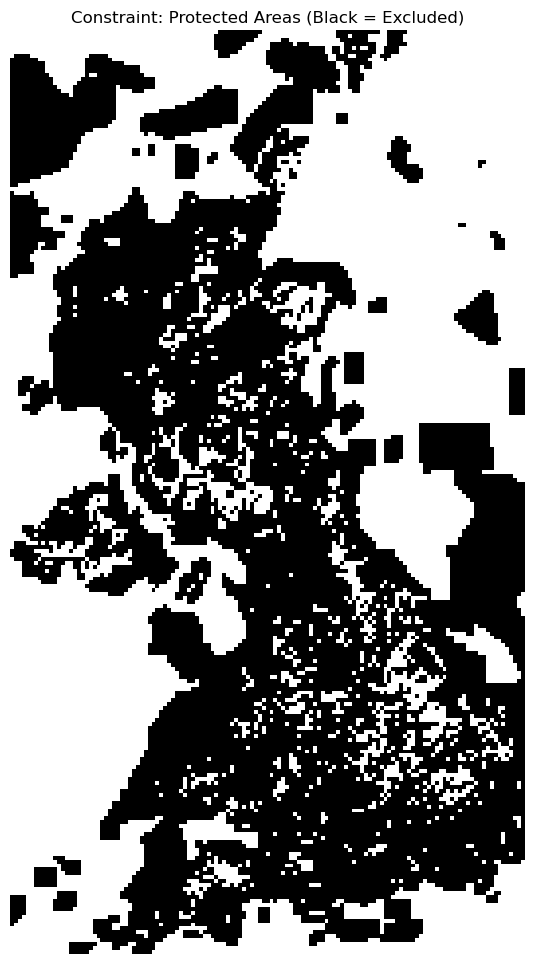

In [139]:
fig, ax = plt.subplots(figsize=(10, 12))

gdf_uk.plot(
    ax=ax, 
    facecolor='White', 
    edgecolor='Black', 
    linewidth=0.5, 
    zorder=1
)

constraint_wdpa.plot(ax=ax, cmap='gray', add_colorbar=False)
ax.set_title("Constraint: Protected Areas (Black = Excluded)")
ax.set_axis_off()
plt.show()

### Land cover constraint

In [140]:
import rioxarray
from rasterio.enums import Resampling
from rioxarray.merge import merge_arrays
import matplotlib.patches as mpatches

lc_gb = rioxarray.open_rasterio("/Users/lingyunhuang/Desktop/BENV0093 spatial/2nd_Assignment-20251126/datasets/Land Cover Map 2024 (25m rasterised land parcels, GB).tif").squeeze()
lc_ni = rioxarray.open_rasterio("/Users/lingyunhuang/Desktop/BENV0093 spatial/2nd_Assignment-20251126/datasets/Land Cover Map 2024 (25m rasterised land parcels, N. Ireland).tif").squeeze()

lc_gb = lc_gb.rio.reproject_match(wind_annual, resampling=Resampling.mode)
lc_ni = lc_ni.rio.reproject_match(wind_annual, resampling=Resampling.mode)


In [141]:
lc_uk = lc_gb.fillna(lc_ni)
lc_uk_rounded = lc_uk.round()

In [142]:
lc_uk_rounded.head()

<xarray.DataArray (band: 3, y: 5, x: 5)> Size: 75B
array([[[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]], dtype=uint8)
Coordinates:
  * band         (band) int64 24B 1 2 3
    spatial_ref  int64 8B 0
  * x            (x) int32 20B 2500 7500 12500 17500 22500
  * y            (y) int32 20B 12500 17500 22500 27500 32500
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     0

In [143]:
### Exclusion List based on UKCEH README
# 1, 2: Woodland
# 8: Fen, marsh and swamp
# 13, 14: Water
# 15-19: Coastal features
# 20, 21: Urban/Suburban
excluded_values = [1, 2, 8, 13, 14, 15, 16, 17, 18, 19, 20, 21]
constraint_landcover = xr.where(lc_uk_rounded.isin(excluded_values), 0, 1)

In [144]:
constraint_landcover
if 'band' in constraint_landcover.dims:
    constraint_landcover = constraint_landcover.isel(band=0)
    constraint_landcover = constraint_landcover.drop_vars('band')

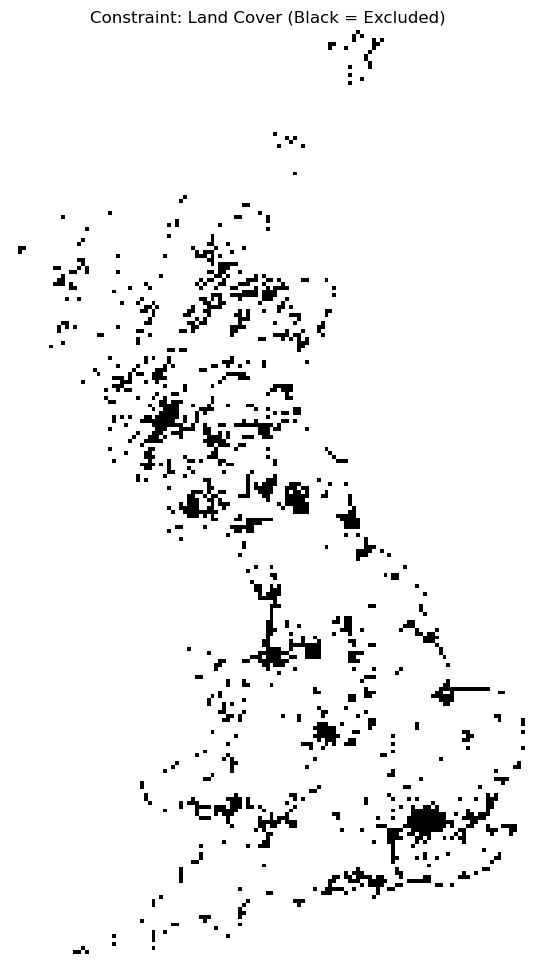

In [145]:
fig, ax = plt.subplots(figsize=(10, 12))

gdf_uk.plot(
    ax=ax, 
    facecolor='white', 
    edgecolor='black', 
    linewidth=0.5, 
    zorder=1
)

constraint_landcover.plot(ax=ax, cmap='grey', add_colorbar=False)
ax.set_title("Constraint: Land Cover (Black = Excluded)")
ax.set_axis_off()
plt.show()

In [146]:
final_constraints = constraint_slope * constraint_wdpa * constraint_landcover

if 'band' in final_constraints.dims:
    final_constraints = final_constraints.isel(band=0)
    final_constraints = final_constraints.drop_vars('band')

final_constraints.rio.write_crs("EPSG:27700", inplace=True)

final_constraints_float = final_constraints.astype(np.float32)
final_constraints_float.rio.write_nodata(np.nan, inplace=True)

final_constraints_land = final_constraints_float.rio.clip(
    gdf_uk.geometry, 
    gdf_uk.crs, 
    drop=True, 
    all_touched=True 
)

# onshore constraints extraction
excluded_points = final_constraints_land.where(final_constraints_land == 0, drop=True)
df_excluded_all = excluded_points.to_dataframe(name='val').reset_index()

df_excluded_all = df_excluded_all[df_excluded_all['val'] == 0]



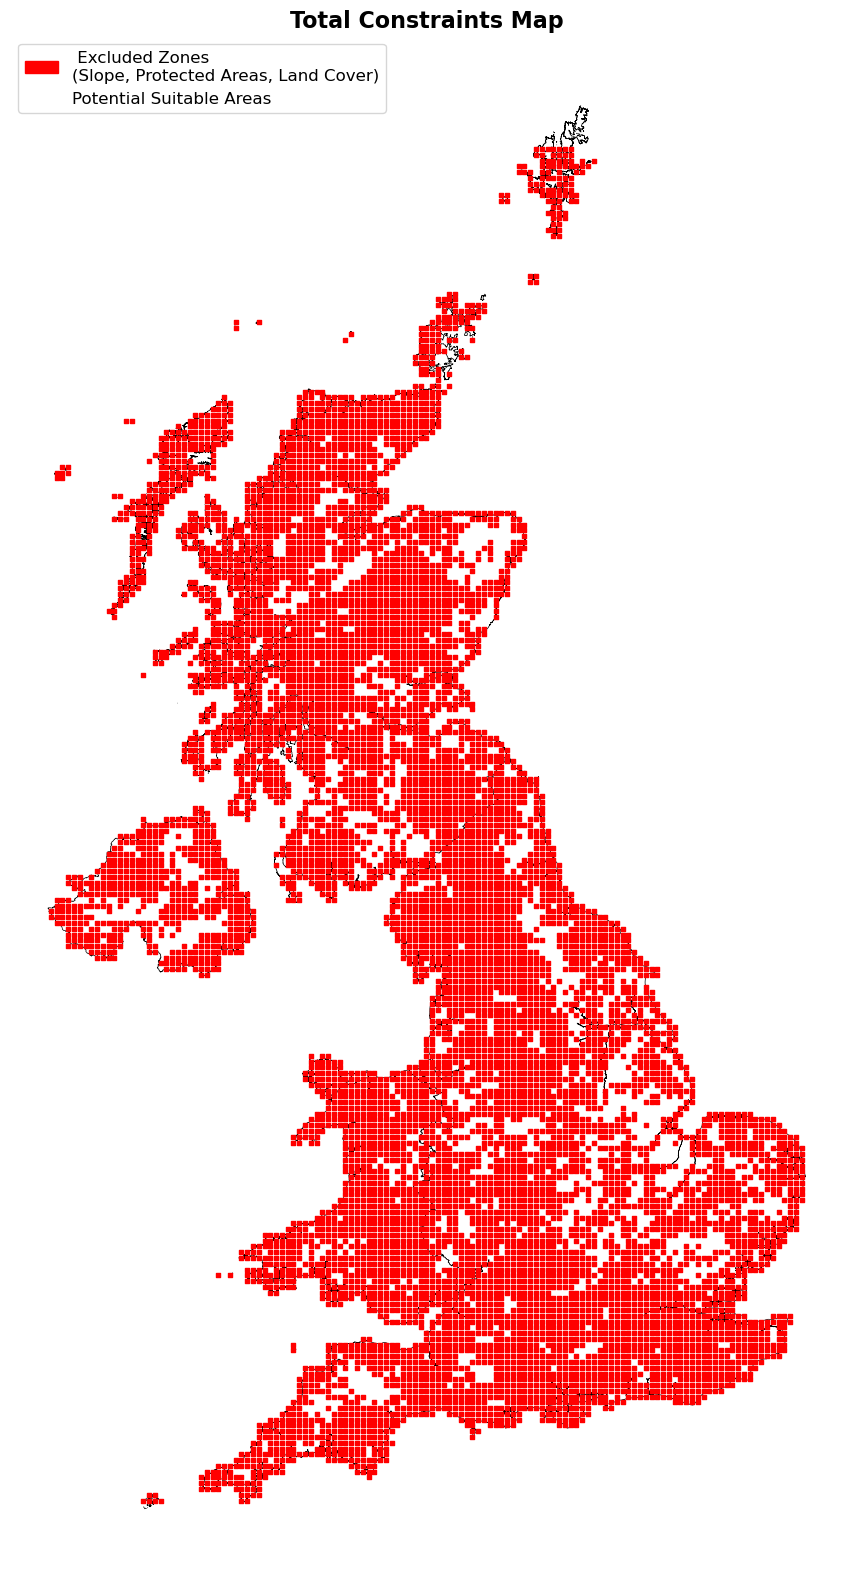

In [147]:
fig, ax = plt.subplots(figsize=(12, 16))

# boundary
gdf_uk.plot(
    ax=ax, 
    facecolor='White', 
    edgecolor='Black', 
    linewidth=0.5, 
    zorder=1
)

# excluded zones
ax.scatter(
    df_excluded_all['x'], 
    df_excluded_all['y'], 
    c='red', 
    s=5,
    marker='s',
    alpha=1,
    label='Combined Exclusion Zones',
    zorder=2
)

red_patch = mpatches.Patch(color='red', label=' Excluded Zones\n(Slope, Protected Areas, Land Cover)')
white_patch = mpatches.Patch(color='white', label='Potential Suitable Areas')

ax.legend(handles=[red_patch, white_patch], loc='upper left', fontsize=12)

ax.set_title("Total Constraints Map", fontsize=16, fontweight='bold')
ax.set_axis_off()

plt.tight_layout()
plt.show()

In [148]:
# AHP Weights
w_wind = 0.669
w_grid = 0.243
w_slope = 0.088

s_wind_aligned = score_wind.rio.reproject_match(final_constraints_land, resampling=Resampling.nearest)
s_grid_aligned = score_distance_optimized.rio.reproject_match(final_constraints_land, resampling=Resampling.nearest)
s_slope_aligned = score_slope.rio.reproject_match(final_constraints_land, resampling=Resampling.nearest)

In [149]:
#Calculate Index
raw_index = (w_wind * s_wind_aligned) + \
            (w_grid * s_grid_aligned) + \
            (w_slope * s_slope_aligned)

#Apply Constraints
final_suitability_map = raw_index.where(final_constraints_land == 1)
final_suitability_map.max().values

array(0.93104537)

In [150]:
valid_pixels = final_suitability_map.count().values

print("number of suitable area:", valid_pixels)

min_score = final_suitability_map.min().values
max_score = final_suitability_map.max().values

print("lowest score", min_score)
print("highest score", max_score)

number of suitable area: 1697
lowest score 0.2575491015280499
highest score 0.9310453654314442


In [151]:
data_to_plot = final_suitability_map.copy()

if 'band' in data_to_plot.dims:
    data_to_plot = data_to_plot.isel(band=0)

data_to_plot = data_to_plot.squeeze()

print(data_to_plot.dims)

('y', 'x')


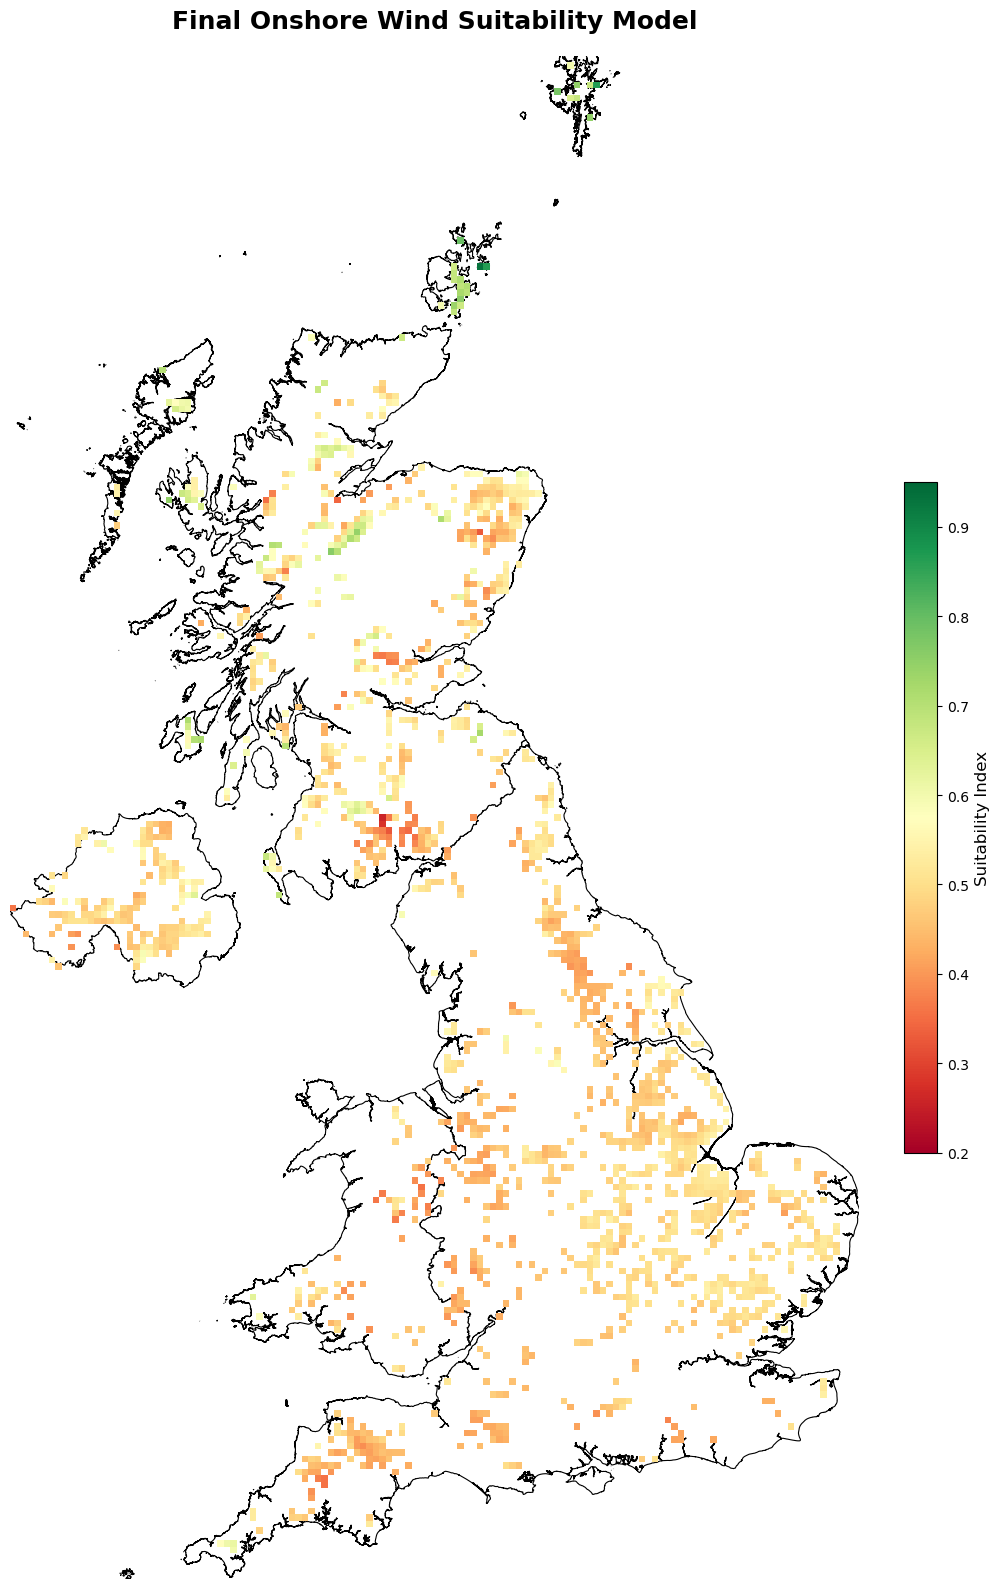

In [152]:
vmin_val = 0.2
vmax_val = 0.95

fig, ax = plt.subplots(figsize=(12, 16))

gdf_uk.plot(
    ax=ax, 
    facecolor='white', 
    edgecolor='black', 
    linewidth=0.8, 
    zorder=1
)

heatmap = data_to_plot.plot.pcolormesh(
    ax=ax,
    cmap='RdYlGn', 
    vmin=vmin_val, 
    vmax=vmax_val,
    add_colorbar=False,
    zorder=2
)

cbar = plt.colorbar(heatmap, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label('Suitability Index', fontsize=12)

ax.set_title("Final Onshore Wind Suitability Model", fontsize=18, fontweight='bold', pad=20)
ax.set_axis_off()

plt.tight_layout()
plt.show()

In [153]:
df = final_suitability_map.to_dataframe(name='score').reset_index()
df = df.dropna()

df = df.sort_values(by='score', ascending=False)
df.head(6)

,y,x,spatial_ref,score
26534,1022500,362500,0,0.931045
30220,1162500,452500,0,0.866655
26535,1022500,367500,0,0.862554
27055,1042500,347500,0,0.791937
30083,1157500,422500,0,0.777299
20747,802500,247500,0,0.758574


In [154]:
selected_sites = []
min_dist = 35000

for i in range(20):
    best_site = df.iloc[0]
    selected_sites.append(best_site)
    distance = np.sqrt((df['x'] - best_site['x'])**2 + (df['y'] - best_site['y'])**2)
    df = df[distance > min_dist]

final_sites_df = pd.DataFrame(selected_sites)
final_sites_df['Site ID'] = range(1, len(final_sites_df) + 1)

print("Top 20 sites:")
print(final_sites_df[['Site ID', 'x', 'y', 'score']])

Top 20 sites:
       Site ID         x          y     score
26534        1  362500.0  1022500.0  0.931045
30220        2  452500.0  1162500.0  0.866655
20747        3  247500.0   802500.0  0.758574
21770        4  122500.0   842500.0  0.747560
25744        5  342500.0   992500.0  0.736662
17102        6  362500.0   662500.0  0.722182
16928        7  147500.0   657500.0  0.717502
21419        8  332500.0   827500.0  0.715280
20869        9  202500.0   807500.0  0.704060
24389       10  117500.0   942500.0  0.698559
16810       11  212500.0   652500.0  0.695818
13796       12  207500.0   537500.0  0.684185
24020       13  237500.0   927500.0  0.673545
25081       14  302500.0   967500.0  0.669220
22842       15  242500.0   882500.0  0.658807
19051       16  282500.0   737500.0  0.658036
15511       17  267500.0   602500.0  0.656941
13783       18  142500.0   537500.0  0.633772
5670        19  187500.0   227500.0  0.628924
21407       20  272500.0   827500.0  0.625257


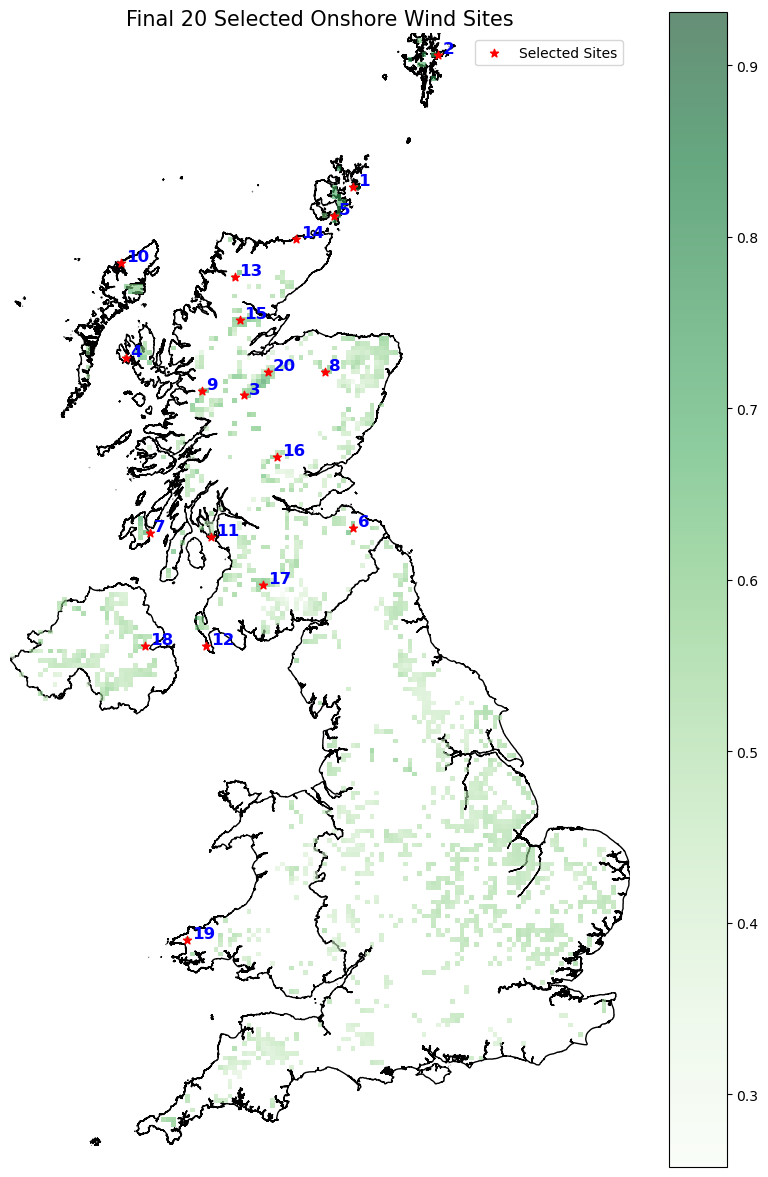

In [155]:
fig, ax = plt.subplots(figsize=(10, 15))

gdf_uk.plot(ax=ax, color='white', edgecolor='black')

final_suitability_map.plot(ax=ax, cmap='Greens', alpha=0.6, add_colorbar=True)

ax.scatter(final_sites_df['x'], final_sites_df['y'], 
           color='red', marker='*', label='Selected Sites')

for idx, row in final_sites_df.iterrows():
    ax.text(row['x'] + 5000, row['y'] + 2000, str(int(row['Site ID'])), fontsize=12, fontweight='bold', color='blue')

ax.set_title("Final 20 Selected Onshore Wind Sites", fontsize=15)
ax.legend()
ax.set_axis_off()

plt.show()

In [156]:
final_sites_df

,y,x,spatial_ref,score,Site ID
26534,1022500.0,362500.0,0.0,0.931045,1
30220,1162500.0,452500.0,0.0,0.866655,2
20747,802500.0,247500.0,0.0,0.758574,3
21770,842500.0,122500.0,0.0,0.747560,4
25744,992500.0,342500.0,0.0,0.736662,5
17102,662500.0,362500.0,0.0,0.722182,6
16928,657500.0,147500.0,0.0,0.717502,7
21419,827500.0,332500.0,0.0,0.715280,8
20869,807500.0,202500.0,0.0,0.704060,9
24389,942500.0,117500.0,0.0,0.698559,10


In [157]:
site_winds = wind_annual.sel(x=final_sites_df['x'].values, y=final_sites_df['y'].values, method='nearest').to_numpy().diagonal()
site_transmission = dist_grid_xr.sel(x=final_sites_df['x'].values, y=final_sites_df['y'].values, method='nearest').to_numpy().diagonal()

In [158]:
final_sites_df['Wind Speed (m/s)'] = site_winds
final_sites_df['Distance to Grid (m)'] = site_transmission
final_sites_df

,y,x,spatial_ref,score,Site ID,Wind Speed (m/s),Distance to Grid (m)
26534,1022500.0,362500.0,0.0,0.931045,1,7.025994,68.785635
30220,1162500.0,452500.0,0.0,0.866655,2,6.955861,11132.919985
20747,802500.0,247500.0,0.0,0.758574,3,6.117041,5880.968618
21770,842500.0,122500.0,0.0,0.747560,4,5.952199,6715.470587
25744,992500.0,342500.0,0.0,0.736662,5,6.492132,24705.637173
17102,662500.0,362500.0,0.0,0.722182,6,5.582519,386.560844
16928,657500.0,147500.0,0.0,0.717502,7,6.029410,10651.626100
21419,827500.0,332500.0,0.0,0.715280,8,5.755287,5248.940192
20869,807500.0,202500.0,0.0,0.704060,9,5.675092,3198.451693
24389,942500.0,117500.0,0.0,0.698559,10,6.212497,23034.215012


# Financial Analysis

based on assumptions:

In [262]:
HUB_HEIGHT = 70
REF_HEIGHT = 10
ALPHA = 1/7
ELECTRICITY_PRICE_USD_PER_MWh = 103
CAPEX_INSTALL_USD_PER_MW = 2000000
CAPEX_GRID_USD_PER_MW_KM = 590
OPEX_USD = 0
DISCOUNT_RATE = 0.05
LIFETIME_YEARS = 25
CAPACITY_MW = 500
HOURS_PER_YEAR = 8760
Capacity_Factor = 0.35

From Power to speed

In [263]:
def calc_turbine_speed(speed, turbine_height=70, data_height=10, hellman_exponent=1/7):
    turbine_speed = speed * (turbine_height / data_height) ** hellman_exponent
    return turbine_speed

# Discrete power curve: for wind speeds 0 to 24 m/s
power_curve = np.array([
    0, 0, 0, 102, 257, 471, 750, 1194, 1713, 2227, 2465, 2500,
    2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2400, 2250
])

wind_speeds = np.arange(0, 25)

def speed_to_power(speed_array):
    speed_array = np.clip(speed_array, 0, 24)  # avoid out-of-bounds
    return np.interp(speed_array, wind_speeds, power_curve)

AEP

In [264]:
final_sites_df['AEP (MWh)'] = CAPACITY_MW * HOURS_PER_YEAR * Capacity_Factor

Annual Revenue

In [265]:
final_sites_df['Annual Revenue ($M)'] = (final_sites_df['AEP (MWh)'] * ELECTRICITY_PRICE_USD_PER_MWh) / 1000000

CAPEX

In [266]:
cap_install_M = (CAPEX_INSTALL_USD_PER_MW * CAPACITY_MW) / 1000000
final_sites_df['CAPEX Grid ($M)'] = (CAPEX_GRID_USD_PER_MW_KM * CAPACITY_MW * (final_sites_df['Distance to Grid (m)'] / 1000)) / 1000000
final_sites_df['Total CAPEX ($M)'] = cap_install_M + final_sites_df['CAPEX Grid ($M)']

NPV

In [267]:
def calc_NPV(annual_revenue, lifetime_yrs, CAPEX, dis=0.05, OPEX=0):
    t = np.arange(1, lifetime_yrs + 1)
    discounted_cash_flows = (annual_revenue - OPEX) / (1 + dis) ** t
    NPV = discounted_cash_flows.sum() - CAPEX
    return NPV

In [268]:
npv_values = []
AEP_values = []
annual_revenues = []
cf_values = []
try:
    del min
except:
    pass

for idx, row in final_sites_df.iterrows():

    raw_wind_speed = float(wind_annual.sel(x=row['x'], y=row['y'], method='nearest').values)
    turbine_speed = calc_turbine_speed(raw_wind_speed, HUB_HEIGHT, REF_HEIGHT, ALPHA)
    power_output = speed_to_power(np.array([turbine_speed]))[0]
    capacity_factor = min(power_output / 2500.0, 0.40)  # 2500 kW is the rated power
    # AEP
    AEP = CAPACITY_MW * HOURS_PER_YEAR * capacity_factor 
    # annual revenue
    annual_revenue = (AEP * ELECTRICITY_PRICE_USD_PER_MWh) / 1000000  # in $M 

    npv = calc_NPV(
        annual_revenue=annual_revenue,
        lifetime_yrs=LIFETIME_YEARS,
        CAPEX=row['Total CAPEX ($M)'],
        dis=DISCOUNT_RATE,
        OPEX=OPEX_USD
    )
    npv_values.append(npv)
    AEP_values.append(AEP)
    annual_revenues.append(annual_revenue)
    cf_values.append(capacity_factor)


final_sites_df['NPV ($M)'] = npv_values
final_sites_df['AEP (MWh)'] = AEP_values
final_sites_df['Annual Revenue ($M)'] = annual_revenues
final_sites_df['Capacity Factor'] = cf_values

LCOE

In [269]:
def calc_LCOE(capex, opex, annual_generation, lifetime, discount_rate):
    years = np.arange(1, lifetime + 1)
    discount_factors = 1 / (1 + discount_rate) ** years
    total_discounted_cost = capex + np.sum(opex * discount_factors)
    total_discounted_generation = np.sum(annual_generation * discount_factors)
    if total_discounted_generation == 0:
        return np.nan
    lcoe = total_discounted_cost / total_discounted_generation
    return lcoe

In [270]:
lcoe_values = []
AEP_values = []
annual_revenues = []
cf_values = []

for idx, row in final_sites_df.iterrows():

    raw_wind_speed = float(wind_annual.sel(x=row['x'], y=row['y'], method='nearest').values)
    turbine_speed = calc_turbine_speed(raw_wind_speed, HUB_HEIGHT, REF_HEIGHT, ALPHA)
    power_output = speed_to_power(np.array([turbine_speed]))[0]
    capacity_factor = min(power_output / 2500.0, 0.40)  # 2500 kW is the rated power
    # AEP
    AEP = CAPACITY_MW * HOURS_PER_YEAR * capacity_factor 
    # annual revenue
    annual_revenue = (AEP * ELECTRICITY_PRICE_USD_PER_MWh) / 1000000  # in $M 

    lcoe = calc_LCOE(
        capex=row['Total CAPEX ($M)'] * 1000000,  # Convert to $
        opex=OPEX_USD,
        annual_generation=row['AEP (MWh)'],
        lifetime=LIFETIME_YEARS,
        discount_rate=DISCOUNT_RATE
    )
    lcoe_values.append(lcoe)
    AEP_values.append(AEP)
    annual_revenues.append(annual_revenue)
    cf_values.append(capacity_factor)

final_sites_df['LCOE ($/MWh)'] = lcoe_values
final_sites_df['AEP (MWh)'] = AEP_values
final_sites_df['Annual Revenue ($M)'] = annual_revenues
final_sites_df['Capacity Factor'] = cf_values

In [271]:
final_sites_df

,y,x,spatial_ref,score,Site ID,Wind Speed (m/s),Distance to Grid (m),AEP (MWh),Annual Revenue ($M),CAPEX Grid ($M),Total CAPEX ($M),NPV ($M),LCOE ($/MWh),Capacity Factor
26534,1022500.0,362500.0,0.0,0.931045,1,7.025994,68.785635,1.752000e+06,180.456000,0.020292,1000.020292,1543.316569,40.498800,0.400000
30220,1162500.0,452500.0,0.0,0.866655,2,6.955861,11132.919985,1.752000e+06,180.456000,3.284211,1003.284211,1540.052649,40.630982,0.400000
20747,802500.0,247500.0,0.0,0.758574,3,6.117041,5880.968618,1.752000e+06,180.456000,1.734886,1001.734886,1541.601975,40.568237,0.400000
21770,842500.0,122500.0,0.0,0.747560,4,5.952199,6715.470587,1.752000e+06,180.456000,1.981064,1001.981064,1541.355797,40.578207,0.400000
25744,992500.0,342500.0,0.0,0.736662,5,6.492132,24705.637173,1.752000e+06,180.456000,7.288163,1007.288163,1536.048698,40.793134,0.400000
17102,662500.0,362500.0,0.0,0.722182,6,5.582519,386.560844,1.752000e+06,180.456000,0.114035,1000.114035,1543.222825,40.502596,0.400000
16928,657500.0,147500.0,0.0,0.717502,7,6.029410,10651.626100,1.752000e+06,180.456000,3.142230,1003.142230,1540.194631,40.625232,0.400000
21419,827500.0,332500.0,0.0,0.715280,8,5.755287,5248.940192,1.752000e+06,180.456000,1.548437,1001.548437,1541.788423,40.560686,0.400000
20869,807500.0,202500.0,0.0,0.704060,9,5.675092,3198.451693,1.752000e+06,180.456000,0.943543,1000.943543,1542.393317,40.536190,0.400000
24389,942500.0,117500.0,0.0,0.698559,10,6.212497,23034.215012,1.752000e+06,180.456000,6.795093,1006.795093,1536.541767,40.773165,0.400000


In [272]:
avg_npv = final_sites_df['NPV ($M)'].mean()
avg_lcoe = final_sites_df['LCOE ($/MWh)'].mean()
print(f"Average NPV: ${avg_npv:.2f}M")
print(f"Average LCOE: ${avg_lcoe:.2f}/MWh")

Average NPV: $1534.72M
Average LCOE: $40.69/MWh


In [273]:
print(f"Total Portfolio Capacity: {20 * CAPACITY_MW / 1000:.1f} GW")
print(f"Average NPV per site: ${avg_npv:.2f} Million")
print(f"Average LCOE: ${avg_lcoe:.2f} /MWh")


Total Portfolio Capacity: 10.0 GW
Average NPV per site: $1534.72 Million
Average LCOE: $40.69 /MWh
